# Auto Encoders for MNIST

In [146]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

### Model
Using a simple CNN Auto Encoder

In [147]:
# activate for denoising auto-encoder
use_noisy_input = False
get_input_noise = lambda shape: torch.empty(shape).normal_(0.2, 0.1).to(device) if use_noisy_input else 0

In [148]:
bottleneck_dim = 64
class Encoder(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.c1 = nn.Conv2d(1, 16, 5, stride=2, padding=2)
        self.c2 = nn.Conv2d(16, 8, 5, stride=2, padding=2)
        self.l1 = nn.Linear(8 * 7 * 7, bottleneck_dim)
    def forward(self, x):
        y = self.c1(x).relu()
        y = self.c2(y).relu()
        y = y.flatten(start_dim=1)
        return self.l1(y).sigmoid()
class Decoder(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(bottleneck_dim, 8 * 7 * 7)
        self.tc2 = nn.ConvTranspose2d(8, 16, 5, stride=2, padding=2)
        self.tc1 = nn.ConvTranspose2d(16, 1, 5, stride=2, padding=2)
    def forward(self, y):
        x = self.l1(y).relu()
        x = x.reshape(-1, 8, 7, 7)
        x = self.tc2(x, output_size=(None, 32, 14, 14)).relu()
        x = self.tc1(x, output_size=(None, 1, 28, 28)).sigmoid()
        return x
class AutoEncoder(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.l = nn.Linear(bottleneck_dim, 10)
    def forward(self, x):
        z = self.encoder(x)
        x_ = self.decoder(z)
        return x_, self.l(z)

In [149]:
# use device if available
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print("Using Device:", device)
# model and optimizer
model_B = AutoEncoder().to(device)      # model trained purely on reconstructing input
model_A = AutoEncoder().to(device)      # model additionally trained on prediction of labels from z
optim = torch.optim.Adam(list(model_A.parameters()) + list(model_B.parameters()))

Using Device: cuda:0


## Training

In [150]:
# load mnist data
mnist_train = MNIST('./data/', train=True, download=True, transform=ToTensor())
mnist_test = MNIST('./data/', train=False, download=True, transform=ToTensor())
# create dataloaders
mnist_train = torch.utils.data.DataLoader(mnist_train, shuffle=True, batch_size=64)
mnist_test = torch.utils.data.DataLoader(mnist_test, shuffle=False, batch_size=64)

In [151]:
# training the auto-encoder
epochs = 5
with tqdm(total=len(mnist_train) * epochs) as pbar:
    pbar.set_description("Train", refresh=True)
    # train
    losses_A, losses_B = [], []
    model_A.train()
    model_B.train()
    for e in range(epochs):
        for x, y_hat in mnist_train:
            # prepare input
            x = x.to(device)
            x_noise = get_input_noise(x.size())
            # predict both models
            x_A, _ = model_A.forward(x + x_noise)
            x_B, y_B = model_B.forward(x + x_noise)
            # compute losses
            l_A = F.mse_loss(x_A, x)
            l_B = F.mse_loss(x_B, x) + F.cross_entropy(y_B, y_hat.to(device))
            # update
            optim.zero_grad()
            (l_A + l_B).backward()
            optim.step()
            # progress
            losses_A.append(l_A.item())
            losses_B.append(l_B.item())
            pbar.set_postfix({'loss_A': sum(losses_A[-20:]) / min(20, len(losses_A)), 'loss_B': sum(losses_B[-20:]) / min(20, len(losses_B))})
            pbar.update(1)

Train: 100%|██████████| 4690/4690 [01:57<00:00, 40.00it/s, loss_A=0.00751, loss_B=0.0746]


## Bottleneck Analysis

In [152]:
# compute z for the whole test dataset
model_A.eval()
model_B.eval()
with torch.no_grad():
    encode = lambda x: (model_A.encoder(x).cpu(), model_B.encoder(x).cpu())
    z_A, z_B = zip(*[encode(x.to(device)) for x, _ in mnist_test])
    z_A, z_B = map(lambda zs: torch.cat(zs, dim=0).numpy(), (z_A, z_B))
# get test labels
test_labels = mnist_test.dataset.targets.numpy()

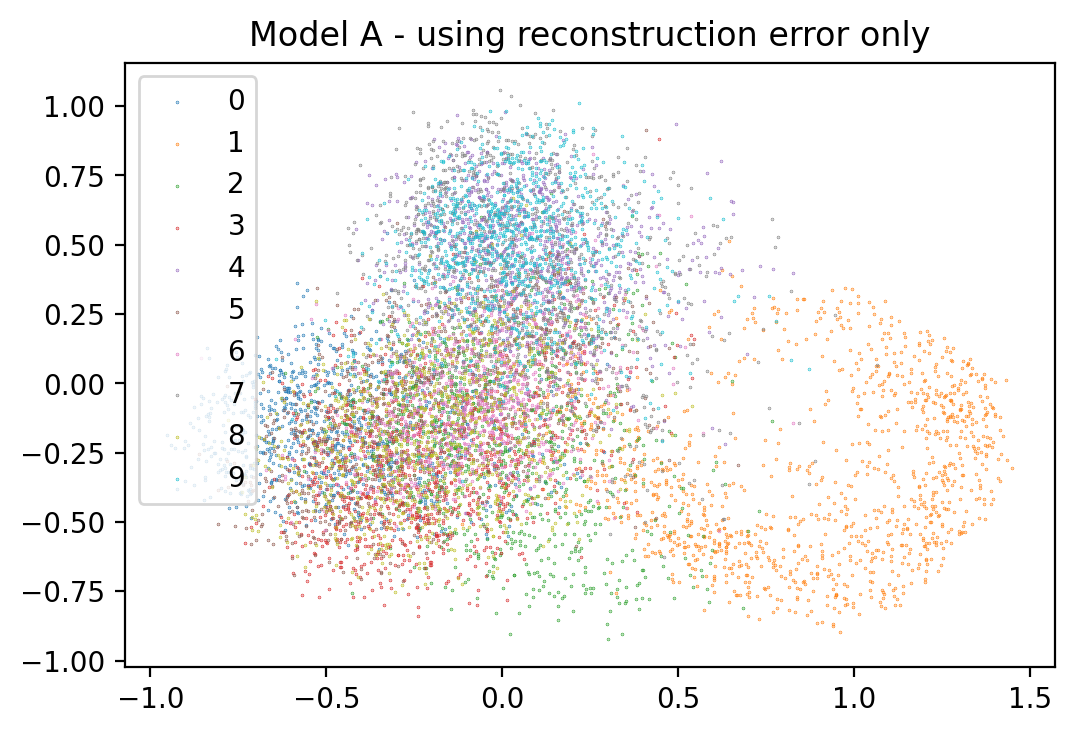

In [153]:
# visualize code/bottleneck of different labels/numbers
z = PCA(n_components=2).fit(z_A).transform(z_A)
for i in range(10):
    zz = z[test_labels == i, :]
    plt.scatter(zz[:, 0], zz[:, 1], s=0.05)
plt.legend(range(10))
plt.title("Model A - using reconstruction error only")
plt.show()

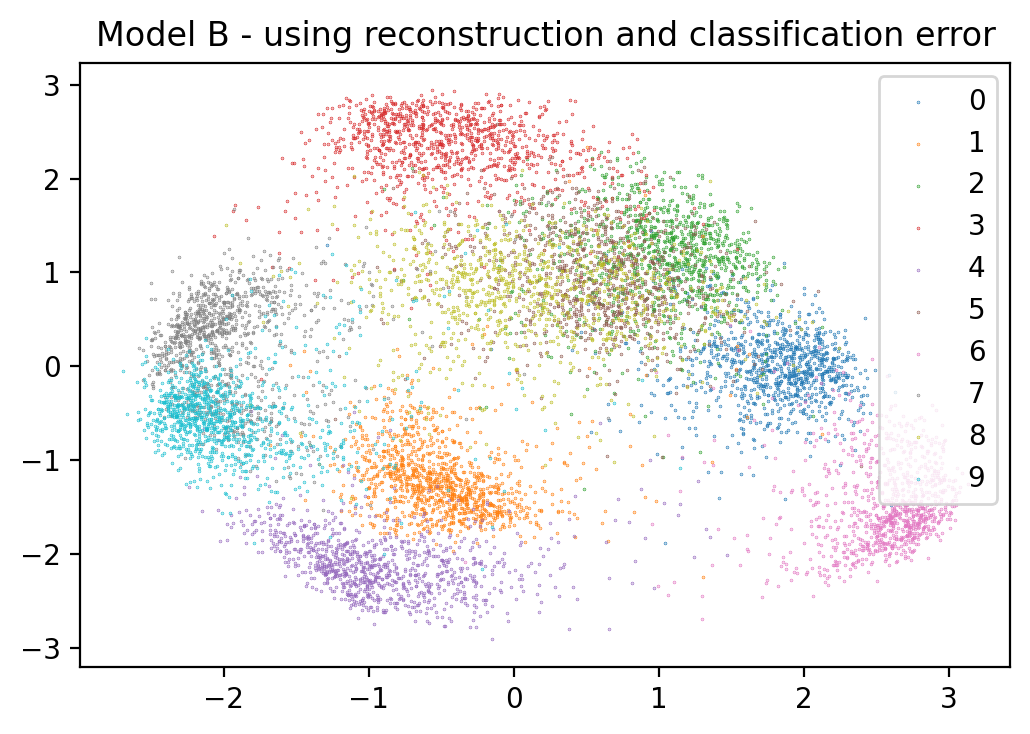

In [154]:
# visualize code/bottleneck of different labels/numbers
z = PCA(n_components=2).fit(z_B).transform(z_B)
for i in range(10):
    zz = z[test_labels == i, :]
    plt.scatter(zz[:, 0], zz[:, 1], s=0.05)
plt.legend(range(10))
plt.title("Model B - using reconstruction and classification error")
plt.show()

## Experiments/Visualization

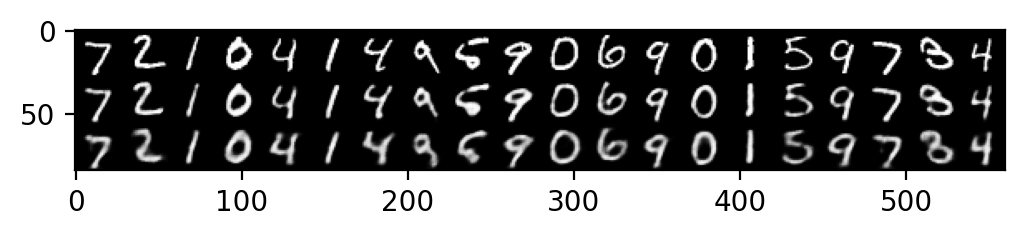

In [155]:
# visualize some example outputs
model_A.eval()
model_B.eval()
with torch.no_grad():
    x = next(iter(mnist_test))[0][:20].to(device)
    x += get_input_noise(x.size())
    x_A, x_B = model_A(x)[0], model_B(x)[0]
# build and show image
img = torch.cat([t.cpu().transpose(0, 2).reshape(28, -1) for t in (x, x_A, x_B)], dim=0).numpy()
plt.imshow(img, cmap='gray')
plt.rcParams['figure.dpi'] = 200
plt.show()

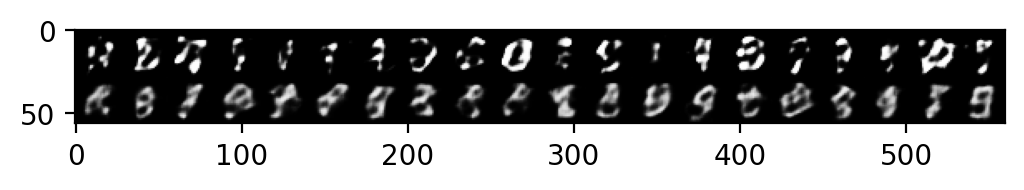

In [156]:
# decode from random
with torch.no_grad():
    z = torch.empty((20, bottleneck_dim)).uniform_(0, 1).to(device)
    x_A, x_B = model_A.decoder(z), model_B.decoder(z)
# build and show image
img = torch.cat([t.cpu().transpose(0, 2).reshape(28, -1) for t in (x_A, x_B)], dim=0).numpy()
plt.imshow(img, cmap='gray')
plt.rcParams['figure.dpi'] = 200
plt.show()